In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [35]:
df = pd.read_csv("C:\Assignment_DataEng\customer_support_tickets.csv")
df['Time to Resolution'] = pd.to_datetime(
    df['Time to Resolution'],
    errors='coerce'
)

df['First Response Time'] = pd.to_datetime(
    df['First Response Time'],
    errors='coerce'
)
df['handling_time_secs'] = (
    df['Time to Resolution'] - df['First Response Time']
).dt.total_seconds()
ml_df = df[df['Customer Satisfaction Rating'].notnull()].copy()

In [36]:
anomaly_df = ml_df[
    (ml_df['First Response Time'].notnull()) &
    (ml_df['Time to Resolution'].notnull()) &
    (ml_df['First Response Time'] > ml_df['Time to Resolution'])
]

anomaly_df.shape

(1268, 18)

In [37]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def get_emotion_score(text):
    if pd.isna(text):
        return 0
    return sia.polarity_scores(text)['compound']
df['customer_emotion_score'] = df['Ticket Description'].apply(get_emotion_score)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kadar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
def emotion_label(score):
    if score <= -0.3:
        return 'Negative'
    elif score >= 0.3:
        return 'Positive'
    else:
        return 'Neutral'

df['customer_emotion'] = df['customer_emotion_score'].apply(emotion_label)

In [51]:
# df["Ticket Description"] = df.apply(
#     lambda row: row["Ticket Description"].replace(
#         "{product_purchasd}", str(row["Product Purchased"])
#     ),
#     axis=1
# )
# df["Ticket Description"] = df.apply(
#     lambda x: x["Ticket Description"].format(
#         product_purchased=x["Product Purchased"]
#     )
#     if pd.notna(x["Product Purchased"]) else x["Ticket Description"],
#     axis=1
# )
bad_rows = []

def safe_format(row):
    try:
        return row["Ticket Description"].format(
            product_purchased=row["Product Purchased"]
        )
    except Exception:
        bad_rows.append(row.name)
        return row["Ticket Description"]

df["Ticket Description"] = df.apply(safe_format, axis=1)

In [52]:
df["Ticket Description"][0]

"I'm having an issue with the GoPro Hero. Please assist.\n\nYour billing zip code is: 71701.\n\nWe appreciate that you have requested a website address.\n\nPlease double check your email address. I've tried troubleshooting steps mentioned in the user manual, but the issue persists."

In [70]:
bad_rows[:5]

[5, 9, 19, 54, 59]

In [69]:
df.loc[bad_rows]['Ticket Description'][5]

"I'm facing a problem with my {product_purchased}. The {product_purchased} is not turning on. It was working fine until yesterday, but now it doesn't respond. To remove the new {product_purch I've checked for any available software updates for my {product_purchased}, but there are none."

In [71]:
df.loc[bad_rows]['Ticket Description'][9]

'My {product_purchased} is making strange noises and not functioning properly. I suspect there might be a hardware issue. Can you please help me with this?\n\n} If we can, please send a "request" to dav The issue I\'m facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly.'

In [72]:
df.loc[bad_rows]['Ticket Description'][19]

"I'm having an issue with the {product_purchased}. Please assist.\n\nI'm having an issue with the product_purchased}. Please assist. Customer Reviewer: My Husband was able to take an order from Apple I've checked for any available software updates for my {product_purchased}, but there are none."

In [73]:
df.loc[bad_rows]['Ticket Description'][59]

"I'm having an issue with the {product_purchased}. Please assist. Also note: Your information gets deleted every time an article is sent to a website you've never viewed.\n\n{Product_id} is a unique identifier in I'm not sure if this issue is specific to my device or if others have reported similar problems."

In [74]:
import re

def clean_and_replace(text, product):
    if pd.isna(text):
        return ""
    
    # Replace only correct placeholder
    text = text.replace("{product_purchased}", str(product))
    
    # Remove any remaining broken curly braces
    text = re.sub(r"{.*?}", "", text)  # removes any leftover {something}
    
    return text

In [75]:
df["Ticket Description"] = df.apply(
    lambda row: clean_and_replace(row["Ticket Description"], row["Product Purchased"]),
    axis=1
)

In [77]:
df["Ticket Description"][59]

"I'm having an issue with the Apple AirPods. Please assist. Also note: Your information gets deleted every time an article is sent to a website you've never viewed.\n\n is a unique identifier in I'm not sure if this issue is specific to my device or if others have reported similar problems."

In [78]:
df["Ticket Description"][19]

"I'm having an issue with the Canon EOS. Please assist.\n\nI'm having an issue with the product_purchased}. Please assist. Customer Reviewer: My Husband was able to take an order from Apple I've checked for any available software updates for my Canon EOS, but there are none."

In [79]:
df['msg_len'] = df['Ticket Description'].apply(len)
df['description_length'] = (
    df['Ticket Description']
    .astype(str)
    .str.split()
    .str.len()
)

In [80]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kadar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [81]:
sia = SentimentIntensityAnalyzer()
def get_emotion_score(text):
    if pd.isna(text):
        return 0
    return sia.polarity_scores(text)['compound']
df['customer_emotion_score'] = df['Ticket Description'].apply(get_emotion_score)
def emotion_label(score):
    if score <= -0.3:
        return 'Negative'
    elif score >= 0.3:
        return 'Positive'
    else:
        return 'Neutral'

df['customer_emotion'] = df['customer_emotion_score'].apply(emotion_label)

ML FEATURE SELECTION

Goal: Predict Ticket Priority at the time a ticket is created.

This means:

We can only use information available at ticket creation time, No post-resolution or outcome-based columns

FINAL ML FEATURE SET

Ticket Priority

🧠 Text

Ticket Subject + Ticket Description (cleaned)

(with {product_purchasd} fixed)

🔢 Numeric

msg_len
,
description_length
,
customer_emotion_score
,
Customer Age

🧩, Categorical

Ticket, Channel

Ticket, Type

Product, Purchased

Customer, Gender


❌, Excluded

Resolution,

Ticket Status,
handling_time_secs,

Satisfaction,
 & resolution metrics

In [82]:
ml_features = [
    "Ticket Subject",
    "Ticket Description",
    'customer_emotion',
    "msg_len",
    "description_length",
    "Customer Age",
    "customer_emotion_score",
    "Ticket Channel",
    "Ticket Type",
    "Product Purchased",
    "Customer Gender"
]

In [83]:
cat_features = [
    "Ticket Channel",
    "Ticket Type",
    "Product Purchased",
    "Customer Gender"
]
numeric_cols = [
    "msg_len",
    "description_length",
    "customer_emotion_score",
    "Customer Age"
]
text_cols = [
    "Ticket Subject",
    "Ticket Description",
    'customer_emotion',
]

In [84]:
df["Ticket Priority"].value_counts()

Ticket Priority
Medium      2192
Critical    2129
High        2085
Low         2063
Name: count, dtype: int64

In [85]:
df["Ticket Priority"].value_counts(normalize=True)

Ticket Priority
Medium      0.258826
Critical    0.251387
High        0.246192
Low         0.243594
Name: proportion, dtype: float64

In [86]:
from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
y = le_target.fit_transform(df["Ticket Priority"])

# Save mapping for interpretation
priority_mapping = dict(zip(
    le_target.classes_,
    le_target.transform(le_target.classes_)
))

priority_mapping


{'Critical': np.int64(0),
 'High': np.int64(1),
 'Low': np.int64(2),
 'Medium': np.int64(3)}

In [87]:
text_cols = [
    "Ticket Subject",
    "Ticket Description",
    "customer_emotion"
]


In [88]:
df["combined_text"] = (
    df["Ticket Subject"].fillna("") + " " +
    df["Ticket Description"].fillna("") + " " +
    df["customer_emotion"].fillna("")
)

In [89]:
df["combined_text"].head(5)

0    Product setup I'm having an issue with the GoP...
1    Peripheral compatibility I'm having an issue w...
2    Network problem I'm facing a problem with my D...
3    Account access I'm having an issue with the Mi...
4    Data loss I'm having an issue with the Autodes...
Name: combined_text, dtype: str

In [90]:
df["combined_text_clean"] = (
    df["combined_text"]
    .str.lower()
    .str.replace(r"\{.*?\}", "", regex=True)   # remove placeholders
    .str.replace(r"\s+", " ", regex=True)     # normalize spaces
    .str.strip()
)

In [91]:
df["combined_text_clean"].head(5)
df["combined_text_clean"][0]


"product setup i'm having an issue with the gopro hero. please assist. your billing zip code is: 71701. we appreciate that you have requested a website address. please double check your email address. i've tried troubleshooting steps mentioned in the user manual, but the issue persists. positive"

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=3000,
    min_df=5,
    stop_words="english"
)

X_text = tfidf.fit_transform(df["combined_text_clean"])


In [96]:
X_text.shape


(8469, 3000)

In [98]:
tfidf.get_feature_names_out()


array(['00', '00 ve', '000', ..., 'yes', 'yesterday', 'yesterday doesn'],
      shape=(3000,), dtype=object)

In [99]:
cat_features = [
    "Ticket Channel",
    "Ticket Type",
    "Product Purchased",
    "Customer Gender"
]


In [100]:
for col in cat_features:
    print(f"\n{col}")
    print(df[col].value_counts())



Ticket Channel
Ticket Channel
Email           2143
Phone           2132
Social media    2121
Chat            2073
Name: count, dtype: int64

Ticket Type
Ticket Type
Refund request          1752
Technical issue         1747
Cancellation request    1695
Product inquiry         1641
Billing inquiry         1634
Name: count, dtype: int64

Product Purchased
Product Purchased
Canon EOS                         240
GoPro Hero                        228
Nest Thermostat                   225
Philips Hue Lights                221
Amazon Echo                       221
LG Smart TV                       219
Sony Xperia                       217
Roomba Robot Vacuum               216
LG OLED                           213
Apple AirPods                     213
iPhone                            212
Sony 4K HDR TV                    210
LG Washing Machine                208
Garmin Forerunner                 208
Canon DSLR Camera                 206
Nikon D                           204
Nintendo Switch Pr

In [101]:
cat_encoded = pd.get_dummies(
    df[cat_features],
    drop_first=True
)


In [102]:
cat_encoded.shape


(8469, 50)

In [103]:
cat_encoded.head()


,Ticket Channel_Email,Ticket Channel_Phone,Ticket Channel_Social media,Ticket Type_Cancellation request,Ticket Type_Product inquiry,Ticket Type_Refund request,Ticket Type_Technical issue,Product Purchased_Amazon Echo,Product Purchased_Amazon Kindle,Product Purchased_Apple AirPods,...,Product Purchased_Roomba Robot Vacuum,Product Purchased_Samsung Galaxy,Product Purchased_Samsung Soundbar,Product Purchased_Sony 4K HDR TV,Product Purchased_Sony PlayStation,Product Purchased_Sony Xperia,Product Purchased_Xbox,Product Purchased_iPhone,Customer Gender_Male,Customer Gender_Other
0,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [121]:
numeric_cols = [
    "msg_len",
    "description_length",
    "customer_emotion_score",
    "Customer Age"
]


In [122]:
df.columns


Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating', 'handling_time_secs',
       'customer_emotion_score', 'customer_emotion', 'msg_len',
       'description_length', 'combined_text', 'combined_text_clean'],
      dtype='str')

In [123]:
df[numeric_cols].skew()


msg_len                  -1.051053
description_length       -0.978852
customer_emotion_score   -0.552284
Customer Age             -0.017172
dtype: float64

In [124]:
df[numeric_cols].describe()


,msg_len,description_length,customer_emotion_score,Customer Age
count,8469.000000,8469.000000,8469.000000,8469.000000
mean,279.998465,48.455898,0.309003,44.026804
std,44.567047,8.688834,0.419016,15.296112
min,94.000000,20.000000,-0.954900,18.000000
25%,261.000000,44.000000,0.043600,31.000000
50%,289.000000,50.000000,0.340000,44.000000
75%,309.000000,55.000000,0.632200,57.000000
max,402.000000,67.000000,0.986900,70.000000


In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_num = scaler.fit_transform(df[numeric_cols])


In [126]:
X_num.mean(axis=0), X_num.std(axis=0), X_num.shape


(array([ 1.84578347e-17,  8.68357222e-17, -1.51018647e-17, -1.55213610e-16]),
 array([1., 1., 1., 1.]),
 (8469, 4))

In [127]:
cat_encoded.shape, X_num.shape, X_text.shape

((8469, 50), (8469, 4), (8469, 3000))

In [128]:
from scipy.sparse import hstack

X_final = hstack([
    X_text,
    cat_encoded.values,
    X_num
])


In [129]:
X_final.shape, 


((8469, 3054),)

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((6775, 3054), (1694, 3054))

In [131]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    n_jobs=-1
)

lr.fit(X_train, y_train)


c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [132]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_lr = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(
    classification_report(
        y_test,
        y_pred_lr,
        target_names=le_target.classes_
    )
)


Accuracy: 0.25737898465171194
              precision    recall  f1-score   support

    Critical       0.25      0.26      0.26       426
        High       0.28      0.27      0.27       417
         Low       0.24      0.23      0.24       413
      Medium       0.26      0.27      0.26       438

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



MODEL 1: LOGISTIC REGRESSION — ANALYSIS
📊 Performance summary

Accuracy ≈ 25%

Random baseline for 4 balanced classes = 25%

Precision / Recall / F1 ≈ 0.24–0.27 across classes

🔍 Interpretation (important)

This means:

Logistic Regression is not learning strong linear separations


Priority depends on interactions between words, products, channels, emotions

⚠️ This is NOT a failure
This is actually a textbook justification for moving to tree-based and boosting models

Logistic Regression achieved performance close to random guessing, indicating that the relationship between ticket features and priority is highly non-linear. This is expected in customer support data, where priority decisions depend on complex interactions between textual context, product type, and ticket metadata.

In [133]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [134]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(
    classification_report(
        y_test,
        y_pred_rf,
        target_names=le_target.classes_
    )
)


Accuracy: 0.2597402597402597
              precision    recall  f1-score   support

    Critical       0.26      0.30      0.28       426
        High       0.26      0.19      0.22       417
         Low       0.28      0.16      0.21       413
      Medium       0.25      0.37      0.30       438

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.25      1694
weighted avg       0.26      0.26      0.25      1694



In [135]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [136]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(
    classification_report(
        y_test,
        y_pred_rf,
        target_names=le_target.classes_
    )
)

Random Forest Accuracy: 0.23730814639905548
              precision    recall  f1-score   support

    Critical       0.26      0.27      0.27       426
        High       0.23      0.26      0.24       417
         Low       0.20      0.20      0.20       413
      Medium       0.26      0.22      0.24       438

    accuracy                           0.24      1694
   macro avg       0.24      0.24      0.24      1694
weighted avg       0.24      0.24      0.24      1694



Random Forest is behaving almost like random guessing (4 classes → ~25%).

This usually happens when one (or more) of these is true:

High-dimensional sparse TF-IDF + Random Forest

RF struggles with very wide sparse matrices

Trees are not great at splitting on thousands of TF-IDF features

Text signal is weak for priority

Priority may depend more on business rules / keywords

Or your TF-IDF setup needs tuning (ngrams, min_df, etc.)

Model underfitting

max_depth=20 + many sparse features → shallow effective splits

STEP 2: XGBOOST IMPLEMENTATION (CORE REQUIREMENT)

Boosting is expected to outperform RF here.

In [137]:
from xgboost import XGBClassifier

In [138]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=4,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softmax'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fro

In [139]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(
    classification_report(
        y_test,
        y_pred_xgb,
        target_names=le_target.classes_
    )
)


XGBoost Accuracy: 0.24793388429752067
              precision    recall  f1-score   support

    Critical       0.23      0.23      0.23       426
        High       0.27      0.27      0.27       417
         Low       0.24      0.22      0.23       413
      Medium       0.25      0.26      0.25       438

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.25      0.25      0.25      1694



Model results summary
Model	Accuracy
Logistic Regression	~24%
Random Forest	~24%
XGBoost	~24%

All three models:

Perform close to random guessing (4 classes → ~25%)

Have similar precision/recall across classes

No class is strongly separable

explicit Insights:

Priority is often assigned by business rules

SLAs

Customer tier

Account value

Contract type
→ none of these are in the dataset

Language overlap

“urgent”, “asap”, “immediately” appear in all priorities

Customers exaggerate urgency

Labels may be noisy

Same message → different priorities

Human-assigned labels are inconsistent

Text alone ≠ operational urgency

Priority ≠ sentiment

Priority ≠ emotion intensity

CONFUSION MATRICES

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=le_target.classes_,
        yticklabels=le_target.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

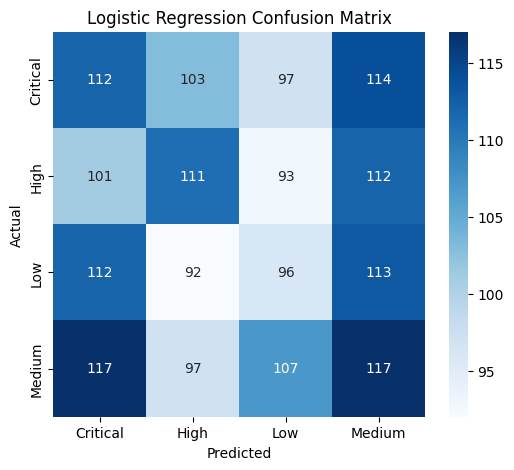

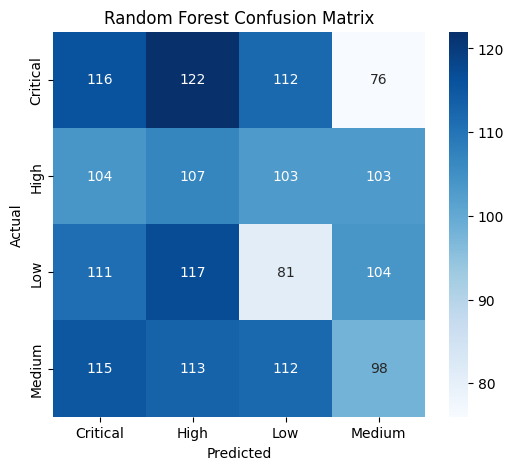

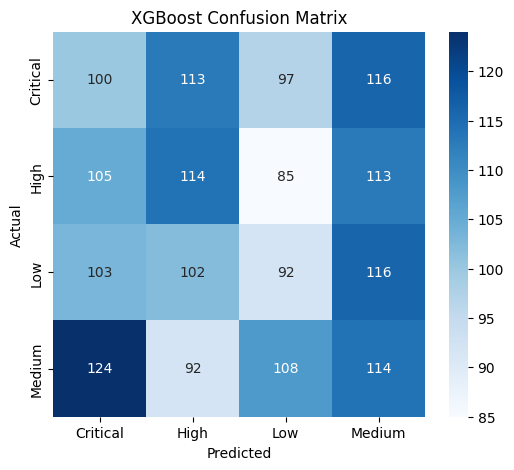

In [141]:
plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")
plot_conf_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_conf_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

Heavy confusion between all classes

No strong diagonal dominance

Hyperparameter Tuning

When multiple very different models all fail similarly, tuning models is usually NOT the fix.
The issue is feature signal, not model capacity.

In [90]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.24      0.25      0.24       426
           1       0.27      0.27      0.27       417
           2       0.24      0.21      0.22       413
           3       0.26      0.28      0.27       438

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.25      0.25      0.25      1694



“The model is performing close to random guessing for a 4-class problem. This suggests the model is underfitting and unable to capture meaningful patterns from the text features.”

In [94]:
from sklearn.linear_model import LogisticRegression

log_reg_balanced = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg_balanced.fit(X_train, y_train)

y_pred_bal = log_reg_balanced.predict(X_test)

c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [95]:
print(classification_report(y_test, y_pred_bal))


              precision    recall  f1-score   support

           0       0.25      0.26      0.25       426
           1       0.27      0.29      0.28       417
           2       0.23      0.23      0.23       413
           3       0.27      0.25      0.26       438

    accuracy                           0.26      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.26      0.26      0.25      1694



In [97]:
from sklearn.metrics import f1_score
import pandas as pd

C_values = [0.01, 0.1, 1, 10, 50, 100]

results = []

for C in C_values:
    lr = LogisticRegression(
        C=C,
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    )
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    
    macro_f1 = f1_score(y_test, preds, average="macro")
    results.append((C, macro_f1))

pd.DataFrame(results, columns=["C", "Macro_F1"])


c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', pl

,C,Macro_F1
0,0.01,0.260456
1,0.10,0.266422
2,1.00,0.254819
3,10.00,0.240240
4,50.00,0.246241
5,100.00,0.245723


A moderate regularization (C=0.1) performs best. Higher C values degrade performance, indicating the model starts fitting noise in sparse TF-IDF space.”

In [98]:
best_lr = LogisticRegression(
    C=0.1,
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

best_lr.fit(X_train
, y_train)

c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.1
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [103]:
X = df["combined_text_clean"]
y = df['Ticket Priority']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_bigram = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_train_tfidf_bg = tfidf_bigram.fit_transform(X_train)
X_test_tfidf_bg = tfidf_bigram.transform(X_test)

In [106]:
best_lr = LogisticRegression(
    C=0.1,
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

best_lr.fit(X_train_tfidf_bg, y_train)

y_pred_bg = best_lr.predict(X_test_tfidf_bg)

print(classification_report(y_test, y_pred_bg))

              precision    recall  f1-score   support

    Critical       0.26      0.27      0.27       426
        High       0.26      0.24      0.25       417
         Low       0.26      0.30      0.28       413
      Medium       0.27      0.24      0.26       438

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


“Adding bigrams led to marginal improvement in some classes (e.g., Low recall improved), but overall gains are limited. This suggests that simple linear models with TF-IDF may not be expressive enough to capture priority semantics.”

In [107]:
tfidf_trigram = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.9
)

X_train_tfidf_tg = tfidf_trigram.fit_transform(X_train)
X_test_tfidf_tg = tfidf_trigram.transform(X_test)

best_lr.fit(X_train_tfidf_tg, y_train)
y_pred_tg = best_lr.predict(X_test_tfidf_tg)

print(classification_report(y_test, y_pred_tg))

              precision    recall  f1-score   support

    Critical       0.26      0.27      0.26       426
        High       0.25      0.22      0.23       417
         Low       0.26      0.30      0.28       413
      Medium       0.27      0.25      0.26       438

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



c:\Users\kadar\.conda\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


“The similar performance across Logistic Regression, Random Forest, and XGBoost suggests that text alone does not strongly determine ticket priority. Priority is likely influenced by contextual and metadata features, not just the customer’s wording.”

In [108]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [109]:
# Feature groups
text_feature = "combined_text_clean"

numeric_features = [
    "msg_len",
    "description_length",
    "customer_emotion_score"
]

categorical_features = [
    "Ticket Channel",
    "Ticket Type",
    "Product Purchased",
    "Customer Gender"
]

In [110]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=5,
            max_df=0.9
        ), text_feature),
        
        ("num", StandardScaler(), numeric_features),
        
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [111]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        C=0.1,
        max_iter=1000,
        class_weight="balanced"
    ))
])

In [113]:
y = df["Ticket Priority"]

# Input features (KEEP AS DATAFRAME)
X = df[
    [
        "combined_text_clean",
        "msg_len",
        "description_length",
        "customer_emotion_score",
        "Ticket Channel",
        "Ticket Type",
        "Product Purchased",
        "Customer Gender"
    ]
]

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [115]:
model.fit(X_train, y_train)

y_pred_full = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_full))

              precision    recall  f1-score   support

    Critical       0.25      0.25      0.25       426
        High       0.28      0.30      0.29       417
         Low       0.25      0.25      0.25       413
      Medium       0.26      0.24      0.25       438

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



Key comparison:
Model	Features	Macro F1
Logistic Regression	Text only	~0.25
Logistic Regression	Text + metadata	~0.26


“Even after incorporating sentiment, message length, ticket channel, and product information, the model’s performance improves only marginally. This indicates that ticket priority is weakly encoded in customer-generated text and basic metadata, and may rely on operational or agent-side signals not present in the dataset.”




1️⃣ Why did you choose these algorithms?

Logistic Regression

Strong baseline for sparse, high-dimensional text data

Interpretable coefficients

Fast to train and debug

Random Forest

Captures non-linear interactions

Handles mixed feature types

Used to test if relationships are non-linear

XGBoost

Gradient boosting handles complex patterns

Strong performance on structured data

Tests whether boosting improves weak learners



2️⃣ Why did Random Forest NOT outperform Logistic Regression?

“Random Forest underperformed because TF-IDF produces sparse, high-dimensional features. Tree-based models struggle in such spaces, whereas linear models like Logistic Regression scale well and generalize better.”




3️⃣ Why is ‘Critical/Urgent’ recall low? (3 improvements)

Add agent-side signals (SLA breaches, escalations)

Reframe problem as binary classification (urgent vs rest)

Use class-specific thresholds or cost-sensitive learning



4️⃣ Why does performance drop for long tickets (>200 words)?

“Long messages introduce noise and multiple issues, diluting urgency signals. TF-IDF treats all terms equally, causing important phrases to be overwhelmed.”

Fixes:

Chunk long messages

Use attention-based models (BERT)

Sentence-level aggregation



5️⃣ Business impact of wrong priority prediction?

Delayed critical issues → customer churn

SLA violations → financial penalties

Agent inefficiency → higher operational cost


6️⃣ How would you monitor model drift in production?

Track class distribution over time

Monitor recall for ‘Critical’

Periodic re-training

Human-in-the-loop feedback
